 # XGBoost Demand-Forecast Model

In [1]:
import pickle
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV

## Load Data

In [2]:
with open('../resources/2_dataframes.pkl', 'rb') as f:
    dataframes = pickle.load(f)

In [3]:
df_holiday_events = dataframes['df_holiday_events']
df_items = dataframes['df_items']
df_oil = dataframes['df_oil']
df_stores = dataframes['df_stores']
df_transactions = dataframes['df_transactions']
df_train = dataframes['df_train']
df_filtered = dataframes['df_filtered']

## Filtering

In the preparation step we filtered for the top 3 item families (`GROCERY I`, `BEVERAGES`, `CLEANING`).

Additionally, we clamp the calendar window from *Jan 1 - Mar 31. 2014*.


In [4]:
min_date = '2014-01-01'
max_date = '2014-04-01'

df_filtered = df_filtered[(df_filtered.index >= min_date) & (df_filtered.index < max_date)]

## Train-Test Split

Chronological split: Training on data from Jan-Feb, testing on March.

In [5]:
df_split_train = df_filtered[df_filtered.index < '2014-03-01']
df_split_test = df_filtered[df_filtered.index >= '2014-03-01']

X_train = df_split_train.drop(columns=['unit_sales'], axis=1)
y_train = df_split_train['unit_sales']

X_test = df_split_test.drop(columns=['unit_sales'], axis=1)
y_test = df_split_test['unit_sales']

## Training XGBoost Model

In [6]:
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=600, max_depth=5, learning_rate=0.01, enable_categorical=True)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

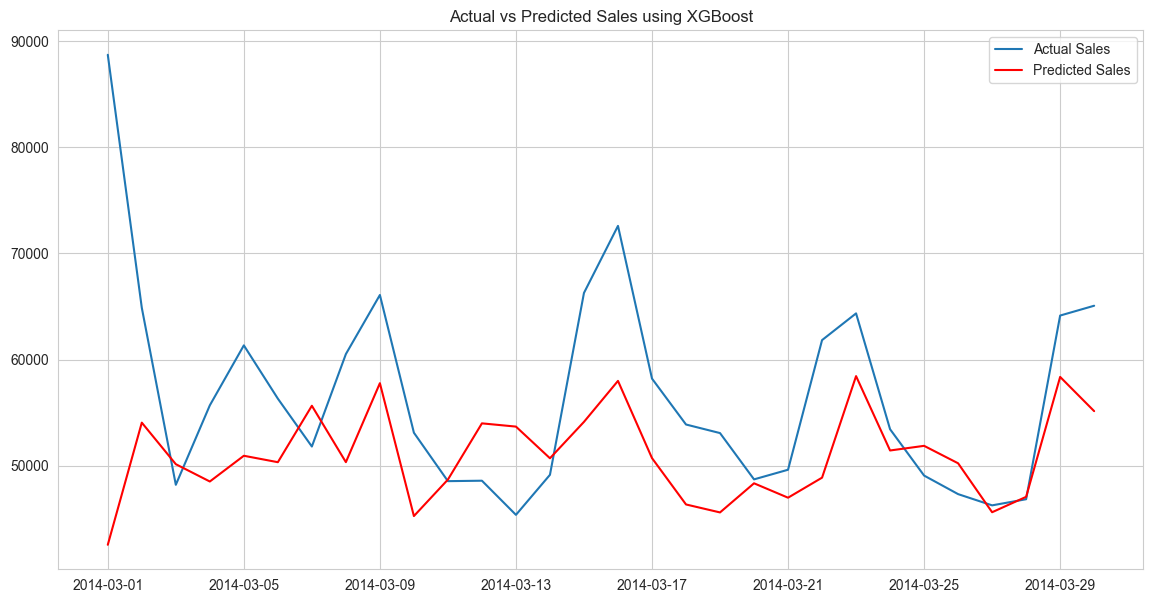

In [7]:
# Zoom window
w_start = 0
w_end = w_start + 30

plt.figure(figsize=(14, 7))
plt.plot(y_test.index[w_start:w_end], y_test.values[w_start:w_end], label='Actual Sales')
plt.plot(y_test.index[w_start:w_end], y_pred[w_start:w_end], label='Predicted Sales', color='red')
plt.title('Actual vs Predicted Sales using XGBoost')
plt.legend()
plt.show()

## Model Evaluation

We will compare MAE, Bias, Mean Absolute Deviation (MAD), Relative Mean Absolute Deviation (RMAE), Mean absolute percentage error (MAPE), and Root Mean Square Error (RMSE).

In [8]:
def xgboost_metrics(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float).flatten()
    y_pred = np.asarray(y_pred, dtype=float).flatten()

    # basic errors
    errors       = y_true - y_pred
    abs_errors   = np.abs(errors)
    pct_errors   = abs_errors / np.where(y_true == 0, np.nan, y_true)   # avoid ÷0

    # core statistics
    mae   = abs_errors.mean()
    bias  = errors.mean()
    rmse  = np.sqrt((errors ** 2).mean())

    # MAD of the ACTUAL series (dispersion of demand itself)
    mad   = np.abs(y_true - y_true.mean()).mean()

    # Relative MAD = MAE divided by MAD  (how big the forecast error is vs. “typical” variation)
    rmad  = mae / mad if mad else np.nan

    # Mean Absolute Percentage Error
    mape  = np.nanmean(pct_errors) * 100   # expressed in %

    return {
        "MAE" : mae,
        "Bias": bias,
        "MAD" : mad,
        "rMAD": rmad,
        "MAPE": mape,
        "RMSE": rmse
    }

metrics = xgboost_metrics(y_test, y_pred)

for key, value in metrics.items():
    print(f"{key}: {value:.2f}")

MAE: 7422.51
Bias: 5671.26
MAD: 7425.74
rMAD: 1.00
MAPE: 11.82
RMSE: 10974.24


**Analysis**:
* **MAE**:
    * The average prediction error is 7422.51 sales units, indicating substantial deviation from actual sales.
* **Bias**:
    * A bias of 5671.26 shows the model is consistently overpredicting demand.
* **MAD*:
    * The median absolute deviation of 7425.74 units suggests high variability in actual sales.
* **rMAD**:
    * The relative MAD of 1.00 means the forecast error is about equal to the typical variation in demand.
* **MAPE**:
    * A mean absolute percentage error of 11.82% indicates moderate accuracy in percentage terms.
* **RMSE**:
    * The root mean square error of 10974.24 confirms large errors in demand prediction.

## Hyperparameter Tuning

In [9]:
xgboost = xgb.XGBRegressor(objective='reg:squarederror')

### Define Parameter Grid

In [10]:
parameters = {
    'eta': [0.01, 0.1, 0.3],                    # Learning rate - smaller is safer but slower
    'max_depth': [3, 5, 7, 10],                 # max depth of each tree - control model complexity
    'subsample': [0.7, 0.8, 1.0],          # fraction per boosting round - control over-fitting
    'colsample_bytree': [0.7, 0.8, 1.0],   # fraction of features per tree - control over-fitting
    'n_estimators': [500, 800, 1000]  # number of boosting rounds
}

### Set up cross validation

In [11]:
tscv = TimeSeriesSplit(n_splits=5)

random_search = RandomizedSearchCV(
    estimator=xgboost,
    param_distributions=parameters,
    cv=tscv, n_iter=10,
    scoring='neg_mean_absolute_error'
)

random_search.fit(X_train, y_train)

best_params = random_search.best_params_

print("Best Parameters for XGBoost:", best_params)

Best Parameters for XGBoost: {'subsample': 0.7, 'n_estimators': 500, 'max_depth': 5, 'eta': 0.01, 'colsample_bytree': 0.7}


### Retrain Model with Best Parameters

In [12]:
best_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    eta=best_params['eta'],
    max_depth=best_params['max_depth'],
    subsample=best_params['subsample'],
    colsample_bytree=best_params['colsample_bytree'],
    n_estimators=best_params['n_estimators'],
    enable_categorical=True
)

best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)

In [13]:
metrics = xgboost_metrics(y_test, y_pred)

for key, value in metrics.items():
    print(f"{key}: {value:.2f}")

MAE: 6319.50
Bias: 4341.28
MAD: 7425.74
rMAD: 0.85
MAPE: 10.15
RMSE: 10036.99


**Analysis**:

* **MAE**:
    * The average prediction error decreased to 6446.41 sales units, showing improved accuracy over the baseline.
* **Bias**:
    * A bias of 3452.98 indicates the model still overpredicts demand, but less than before.
* **RMAD**:
    * The median absolute deviation remains at 7425.74 units, reflecting high variability in actual sales.
* **MAPE**:
    * A mean absolute percentage error of 10.56% suggests slightly better accuracy in percentage terms.
* **RMSE**:
    * The root mean square error dropped to 10170.60, confirming fewer large prediction errors.

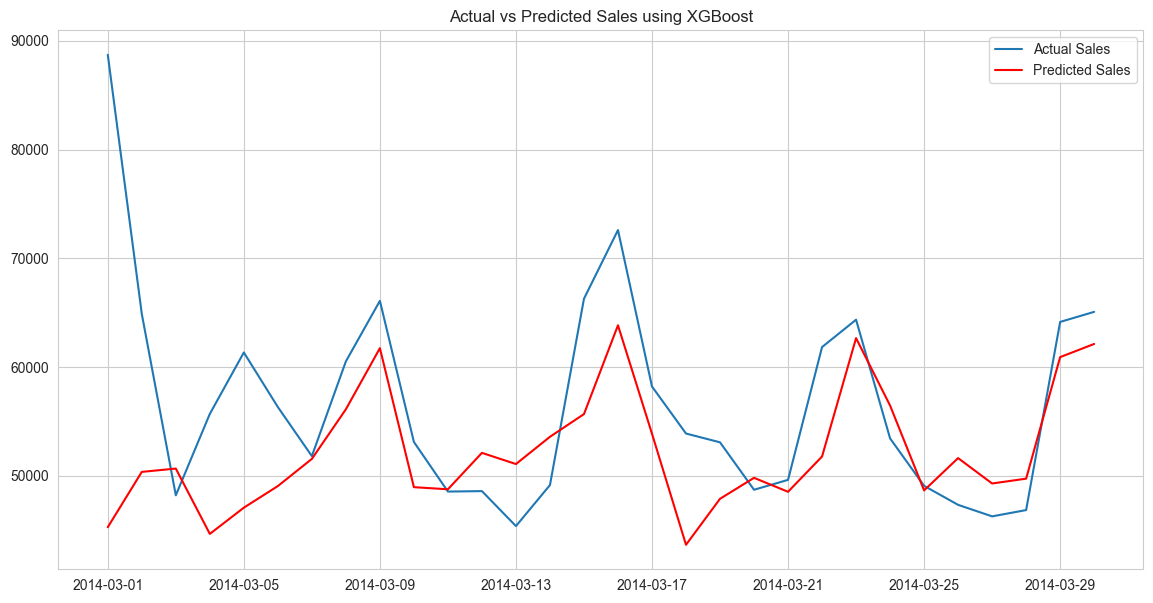

In [14]:
# Zoom window
w_start = 0
w_end = w_start + 30

plt.figure(figsize=(14, 7))
plt.plot(y_test.index[w_start:w_end], y_test.values[w_start:w_end], label='Actual Sales')
plt.plot(y_test.index[w_start:w_end], y_pred[w_start:w_end], label='Predicted Sales', color='red')
plt.title('Actual vs Predicted Sales using XGBoost')
plt.legend()
plt.show()

## Save Model

In [15]:
xgboost_pickle = {
    'model': best_model,
    'parameters': best_params,
}

In [16]:
with open('../resources/3_xgboost_model.pkl', 'wb') as f:
    pickle.dump(xgboost_pickle, f)